In [6]:
import os, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [7]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=7):  # <- Use 7 if original training had 7
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)  # <- Match this
        self.fc2 = nn.Linear(64, num_classes)  # <- Match this too

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [8]:
class MedNISTDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]


In [9]:
from sklearn.model_selection import train_test_split

root_dir = "./data/MedNIST"
classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

image_paths, labels = [], []
for label, class_name in enumerate(classes):
    class_path = os.path.join(root_dir, class_name)
    for img_file in os.listdir(class_path):
        if img_file.lower().endswith((".png", ".jpeg", ".jpg")):
            image_paths.append(os.path.join(class_path, img_file))
            labels.append(label)

_, test_x, _, test_y = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

test_ds = MedNISTDataset(test_x, test_y, transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [11]:
model = CustomCNN(num_classes=7)
model.load_state_dict(torch.load("custom_cnn.pth", map_location=device))
model.to(device)
model.eval()

def evaluate(model, loader):
    correct = total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            preds = model(data).argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    return 100 * correct / total

def measure_inference(model, loader):
    model.eval()
    start = time.time()
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            _ = model(data)
    return time.time() - start

acc = evaluate(model, test_loader)
inf_time = measure_inference(model, test_loader)

print(f"📊 Accuracy: {acc:.2f}%")
print(f"⏱️ Inference Time: {inf_time:.2f} seconds")


📊 Accuracy: 17.10%
⏱️ Inference Time: 21.31 seconds


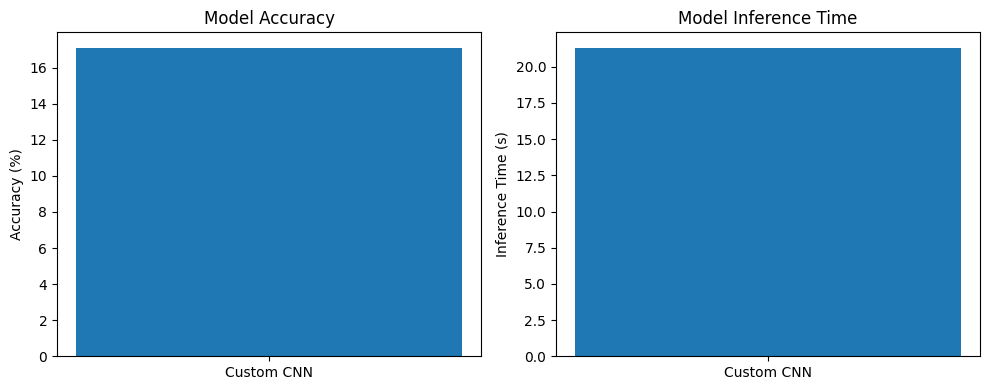

In [12]:
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(["Custom CNN"], [acc])
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy")

# Inference Time
plt.subplot(1, 2, 2)
plt.bar(["Custom CNN"], [inf_time])
plt.ylabel("Inference Time (s)")
plt.title("Model Inference Time")

plt.tight_layout()
plt.show()
